## Intrinsic calibration results plots

In [39]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()
src_path = f"{root}/src"
if src_path not in sys.path:
    sys.path.append(src_path)


In [40]:
base_folder = f"{root}/images/STEREOS"
output_path = f"{root}/data/intrinsic_experiments.csv"
chessboard_size = (9, 6)
square_size_mm = 60

In [42]:
from calibrate_intrinsic import calibrate_camera_from_folder
from itertools import product

experiments = [
    {'threshold': 0, 'win_size': (15, 15)},
    {'threshold': 0, 'win_size': (7, 7)},
    {'threshold': 0, 'win_size': (5, 5)},

    {'threshold': 0.08, 'win_size': (15, 15)},
    {'threshold': 0.08, 'win_size': (7, 7)},
    {'threshold': 0.08, 'win_size': (5, 5)},

    {'threshold': 0.06, 'win_size': (15, 15)},
    {'threshold': 0.06, 'win_size': (7, 7)},
    {'threshold': 0.06, 'win_size': (5, 5)},

    {'threshold': 0.04, 'win_size': (15, 15)},
    {'threshold': 0.04, 'win_size': (7, 7)},
    {'threshold': 0.04, 'win_size': (5, 5)}
]


results = []
for exp in experiments:
  cameras = {
      "CAM_1": os.path.join(base_folder, "STEREO_A/CAMERA_1", "intrinsic_frames"),
      "CAM_2": os.path.join(base_folder, "STEREO_A/CAMERA_2", "intrinsic_frames"),
      "CAM_3": os.path.join(base_folder, "STEREO_B/CAMERA_3", "intrinsic_frames"),
      "CAM_4": os.path.join(base_folder, "STEREO_B/CAMERA_4", "intrinsic_frames"),
  }
  for cam_name, folder in cameras.items():
        try:
            K, D, error, count_before, count_after, NEW_K, roi = calibrate_camera_from_folder(
                folder,
                chessboard_size,
                square_size_mm,
                threshold=exp['threshold'],
                windSize=exp['win_size'],
                with_flags=True,
                apply_filtering=False if exp['threshold'] == 0 else True,
                debug_mode=False
            )
            
            # Store only the main metrics
            result = {
                'camera': cam_name,
                'threshold': exp['threshold'],
                'win_size': exp['win_size'][0],
                'frames_before': count_before,
                'frames_after': count_after,
                'error': round(error, 2)
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error with camera {cam_name}: {e}")
            continue

df = pd.DataFrame(results)
df.to_csv(output_path, index=False)

Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibration error
Error with camera CAM_4: Not enough images after filtering; using initial calibration error
Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibration error
Error with camera CAM_4: Not enough images after filtering; using initial calibration error
Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibr

In [79]:
# load the data from the csv file
original_df = pd.read_csv(output_path)

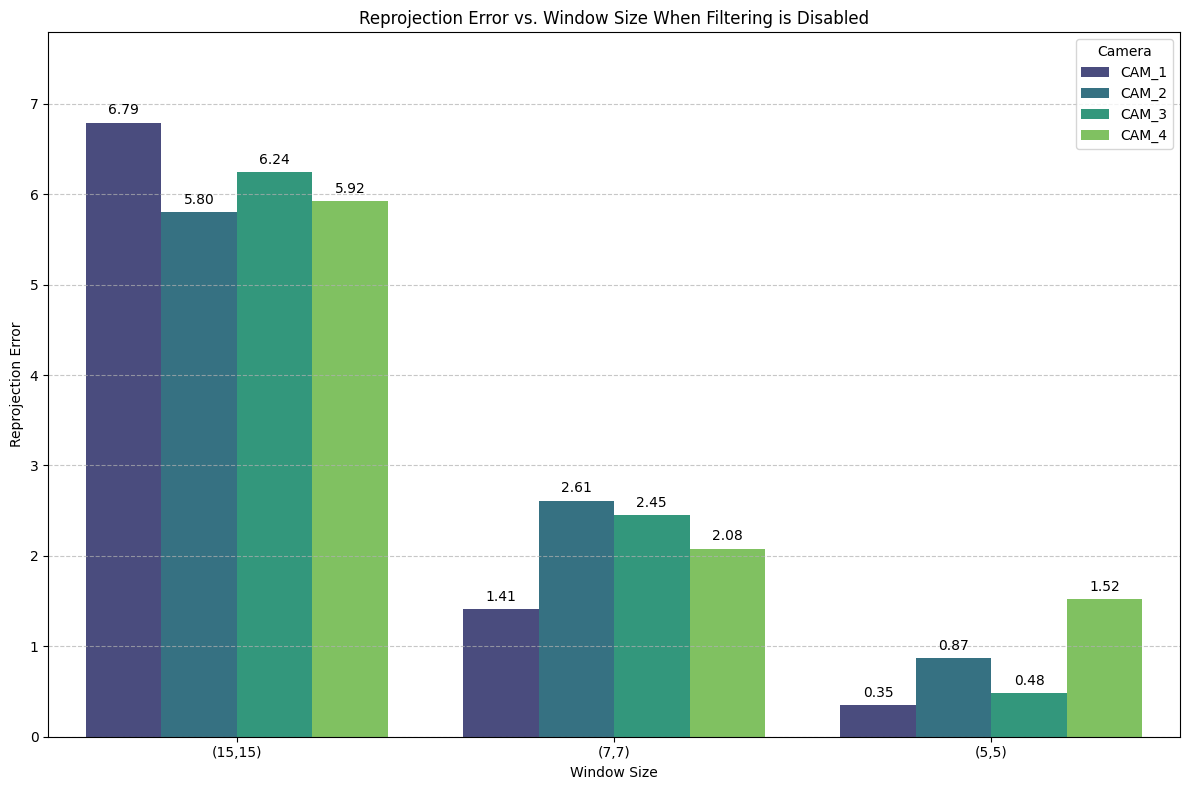

In [87]:
import seaborn as sns

# Filter the data for threshold 0
df_threshold_0 = original_df[original_df['threshold'] == 0]

# Sort the data by reprojection error in descending order
df_threshold_0 = df_threshold_0.sort_values(by='error', ascending=False)

# Plot Reprojection Error vs. Window Size for Threshold 0
plt.figure(figsize=(12, 8))
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']
# Then modify the barplot line to include hue_order:
barplot = sns.barplot(x='win_size', y='error', hue='camera', data=df_threshold_0, palette='viridis', 
                     order=[15, 7, 5], hue_order=camera_order)
plt.title('Reprojection Error vs. Window Size When Filtering is Disabled')
plt.xlabel('Window Size')
plt.ylabel('Reprojection Error')
plt.legend(title='Camera', loc='upper right')
plt.ylim(0, df_threshold_0['error'].max() + 1)  # Adjust y-axis limit for better readability
plt.xticks(ticks=[0, 1, 2], labels=["(15,15)", "(7,7)", "(5,5)"])  # Custom x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Skip annotation for zero values
        barplot.annotate(format(height, '.2f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


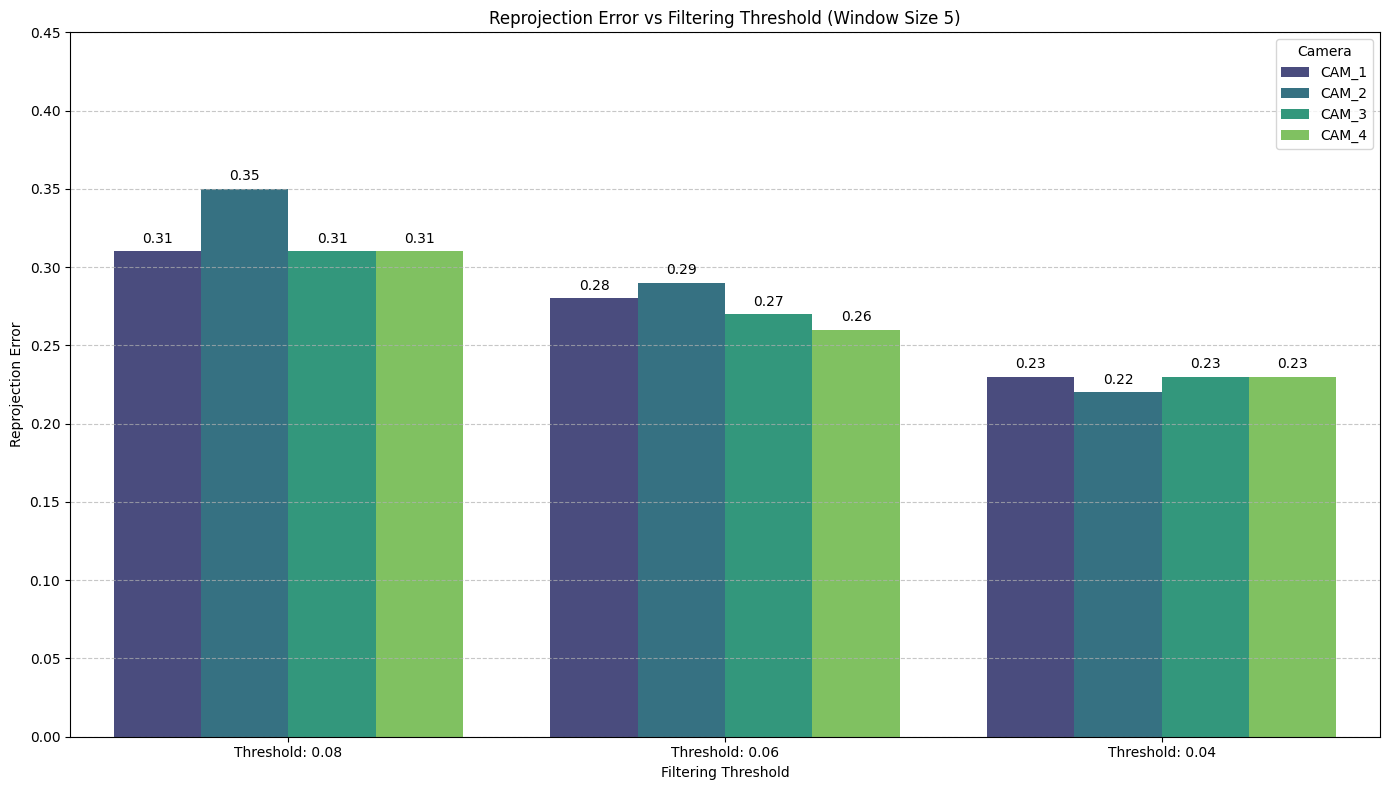

In [88]:
# Filter out experiments with window size 15
df = original_df[original_df['win_size'] != 15]
df = df[df['win_size'] != 7]
df = df[df['threshold'] != 0]

# Create a new column for experiment labels
df['experiment'] = df.apply(lambda row: f"Threshold: {row['threshold']}", axis=1)

# Sort the data by reprojection error in descending order
df = df.sort_values(by='error', ascending=False)

# Plot Reprojection Error for Each Experiment
plt.figure(figsize=(14, 8))
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']
barplot = sns.barplot(x='experiment', y='error', hue='camera', data=df, palette='viridis', hue_order=camera_order)
plt.title('Reprojection Error vs Filtering Threshold (Window Size 5)')
plt.xlabel('Filtering Threshold')
plt.ylabel('Reprojection Error')
plt.legend(title='Camera', loc='upper right')
plt.ylim(0, df['error'].max() + 0.1)  # Adjust y-axis limit for better readability
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact reprojection error values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Skip annotation for zero values
        barplot.annotate(format(height, '.2f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_29705/172559459.py:20: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  barplot = sns.barplot(x='camera', y='frame_count', hue='threshold_label', data=df_combined,


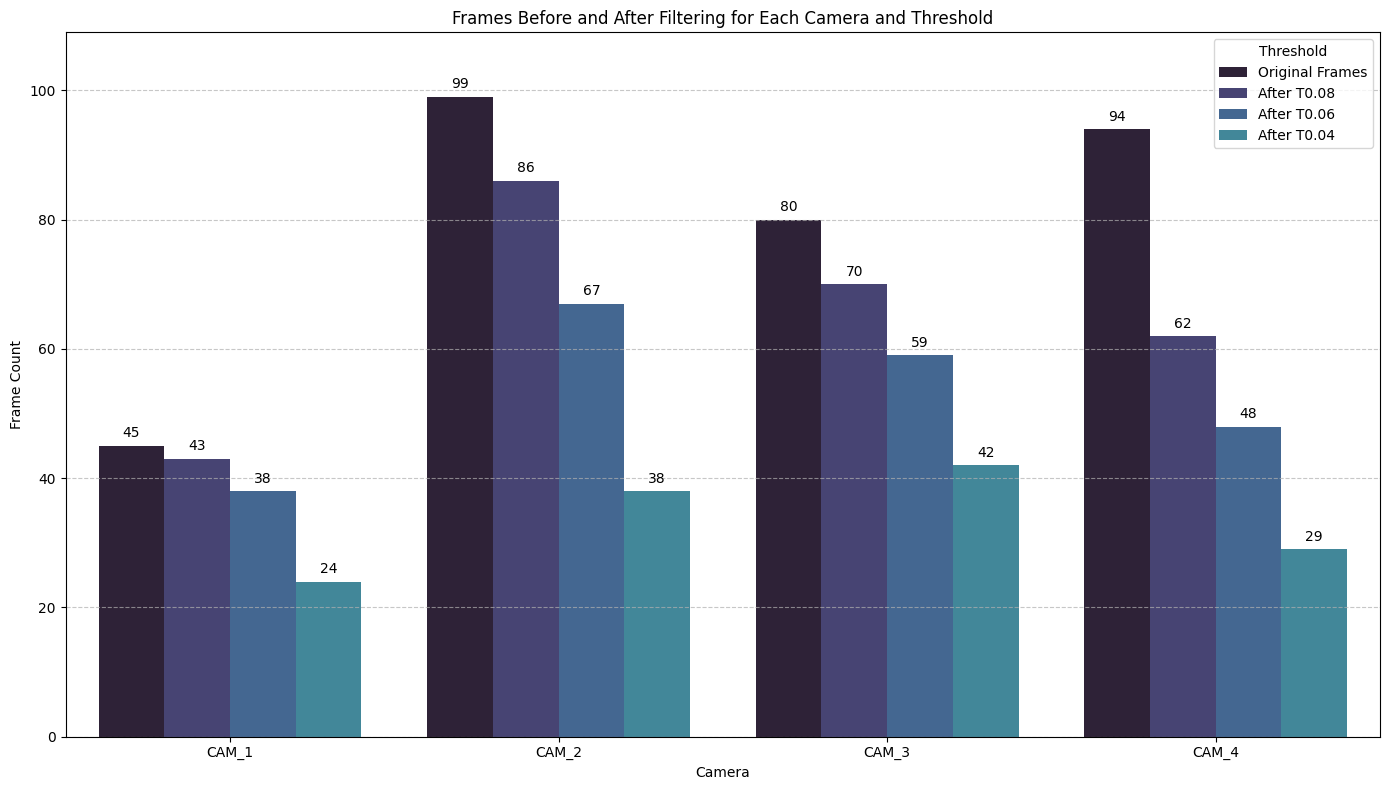

In [113]:
# Filter for window size 5x5
df = original_df[original_df['win_size'] == 5]

# Get frames_after (excluding threshold 0)
df_after = df[df['threshold'] != 0][['camera', 'threshold', 'frames_after']].copy()
df_after['threshold_label'] = df_after['threshold'].apply(lambda x: f'After T{x}')
df_after = df_after.rename(columns={'frames_after': 'frame_count'})

# Add ONE single frames_before entry for each camera
df_before = df[['camera', 'frames_before']].drop_duplicates().copy()
df_before['threshold_label'] = 'Original Frames'
df_before = df_before.rename(columns={'frames_before': 'frame_count'})

# Combine and plot
df_combined = pd.concat([df_before, df_after])
threshold_order = ['Original Frames'] + [f'After T{x}' for x in sorted(df_after['threshold'].unique(), reverse=True)]
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']
plt.figure(figsize=(14, 8))

barplot = sns.barplot(x='camera', y='frame_count', hue='threshold_label', data=df_combined, 
                     palette=sns.color_palette("mako"), errorbar=None, 
                     order=camera_order, hue_order=threshold_order)

plt.title('Frames Before and After Filtering for Each Camera and Threshold')
plt.xlabel('Camera')
plt.ylabel('Frame Count')
plt.legend(title='Threshold', loc='upper right')
plt.ylim(0, df_combined['frame_count'].max() + 10)  # Adjust y-axis limit for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact frame counts
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(format(height, '.0f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_29705/3547928509.py:29: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  barplot = sns.barplot(x='camera', y='frame_count', hue='threshold_label', data=df_combined,


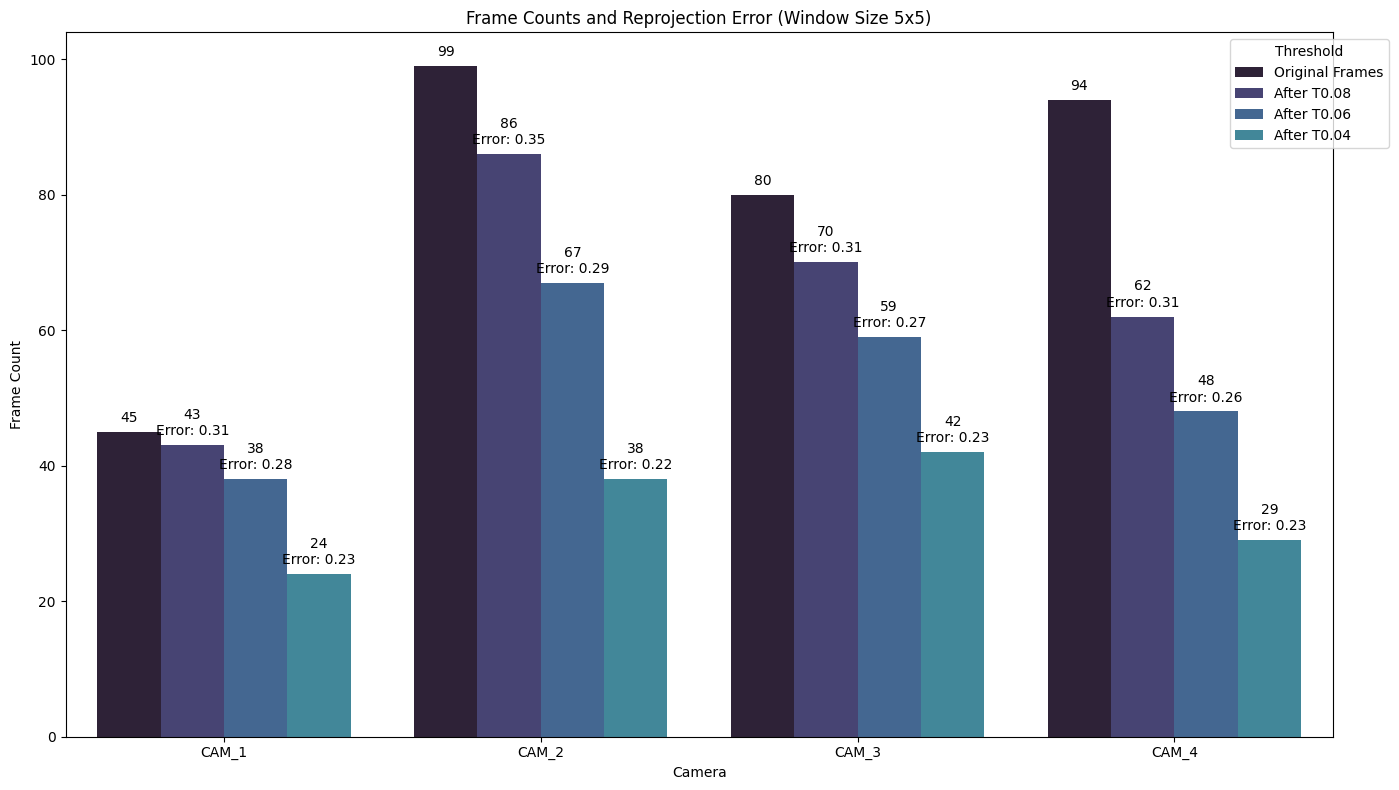

In [120]:
# we only want data about window size 5,5
# threshold 0.04 and 0.06
# and their reprojection error
# with that filtered data, create a table showing:
# thrhold, frames before, frames after, reduction in percentage in frames after with respect to frames before
# and their reprojection error

# Filter for window size 5 and specific thresholds
df_filtered = df[(df['win_size'] == 5) & (df['threshold'].isin([0.08, 0.04, 0.06]))].copy()

# Get frames_after with thresholds and errors
df_after = df_filtered[['camera', 'threshold', 'frames_after', 'error']].copy()
df_after['threshold_label'] = df_after['threshold'].apply(lambda x: f'After T{x}')
df_after = df_after.rename(columns={'frames_after': 'frame_count'})

# Add single original frames count
df_before = df_filtered[['camera', 'frames_before']].drop_duplicates().copy()
df_before['threshold_label'] = 'Original Frames'
df_before = df_before.rename(columns={'frames_before': 'frame_count'})
df_before['error'] = 0  # No error for original frames

# Combine and plot
df_combined = pd.concat([df_before, df_after])
threshold_order = ['Original Frames'] + \
    [f'After T{x}' for x in sorted([0.04, 0.06, 0.08], reverse=True)]
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='camera', y='frame_count', hue='threshold_label', data=df_combined,
                      palette=sns.color_palette("mako"), errorbar=None,
                      order=camera_order, hue_order=threshold_order)

# Annotate with frame count and error
for p, (_, row) in zip(barplot.patches, df_combined.iterrows()):
    height = p.get_height()
    if height > 0:
        error_text = f"\nError: {row['error']:.2f}" if row['threshold_label'] != 'Original Frames' else ""
        barplot.annotate(f"{int(height)}{error_text}",
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points')

plt.title('Frame Counts and Reprojection Error (Window Size 5x5)')
plt.xlabel('Camera')
plt.ylabel('Frame Count')
plt.legend(title='Threshold', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

### Selected values table

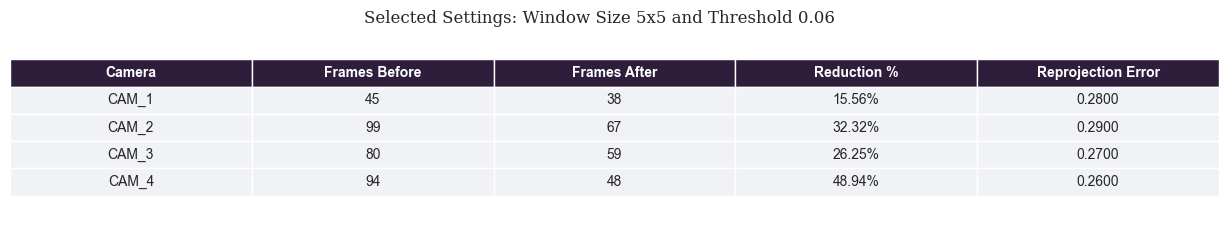

In [131]:
# so the selected values or experiment is the one at threshold 0.06, window size 5x5
# create a table with values for each camera also mention the percentage reduction in the after frames with respect to the before frames
# and the reprojection error

# Filter for the selected experiment
df_selected = original_df[(original_df['win_size'] == 5) & (original_df['threshold'] == 0.06)].copy()

# Create table data
table_data = []
for index, row in df_selected.iterrows():
    frames_reduction = ((row['frames_before'] - row['frames_after']) / row['frames_before']) * 100
    table_data.append([
        row['camera'],
        int(row['frames_before']),
        int(row['frames_after']),
        f"{frames_reduction:.2f}%",
        f"{row['error']:.4f}"
    ])

sns.set_style("whitegrid")
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=table_data,
                colLabels=['Camera', 'Frames Before', 'Frames After', 'Reduction %', 'Reprojection Error'],
                cellLoc='center',
                loc='center',
                colColours=[sns.color_palette("mako")[0]]*5)  # Use seaborn color for header

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.3, 1.7)

# Style the cells
for cell in table._cells:
    table._cells[cell].set_edgecolor('#FFFFFF')  # White edges
    if cell[0] == 0:  # Header row
        table._cells[cell].set_text_props(color='white', weight='bold')
        table._cells[cell].set_facecolor(sns.color_palette("mako")[0])
    else:  # Data rows
        table._cells[cell].set_facecolor('#F0F2F6')  # Light gray background

plt.suptitle('Selected Settings: Window Size 5x5 and Threshold 0.06', 
             y=0.95,
             fontsize=12,
             fontweight='medium',
             fontfamily='serif')

plt.subplots_adjust(top=0.85)
# plt.savefig('frame_reduction_table.png', 
#             dpi=300,
#             bbox_inches='tight',
#             facecolor='white')
plt.show()